# 0.0 - IMPORTS

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import dataframe_image as dfi

import inflection
import requests
import pickle
import locale
import warnings
warnings.filterwarnings('ignore')

from IPython.core.display      import HTML
from IPython.display           import Image
from category_encoders         import TargetEncoder
from sklearn                   import metrics
from sklearn.preprocessing     import MinMaxScaler, LabelEncoder
from sklearn.model_selection   import train_test_split, RandomizedSearchCV
from sklearn.ensemble          import RandomForestRegressor
from sklearn.metrics           import mean_absolute_error, mean_squared_error 
from sklearn.linear_model      import LinearRegression, Lasso
from sklearn.model_selection   import cross_val_score
from sklearn.ensemble          import RandomForestRegressor
from boruta                    import BorutaPy
from tabulate                  import tabulate
from pprint                    import pprint
from flask                     import Flask, request, Response


from scipy import stats as ss
import xgboost as xgb

## 0.1 Helper Funcitons 

In [3]:
def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
            
        #training and validation dataset
        #training
        xtraining = x_training.drop(['item_outlet_sales'], axis=1)
        ytraining = x_training['item_outlet_sales']
        
        #validation
        xvalidation = x_training.drop(['item_outlet_sales'], axis=1)
        yvalidation = x_training['item_outlet_sales']
        
        #model
        m = model.fit(xtraining, ytraining)
        
        #prediction
        yhat = m.predict(xvalidation)
        
        #performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        
        #store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
        
    return pd.DataFrame({'Model Name': model_name,
                        'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                        'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                        'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str),}, index=[0]) 

#def cross_validation(model_name, model, x_train, y_train, k):
    accuracy = np.mean(cross_val_score(model, x_train, y_train, cv=k))
    rmse = np.mean(cross_val_score(model, x_train, y_train, cv=k, scoring = 'neg_root_mean_squared_error'))
    mae = np.mean(cross_val_score(model, x_train, y_train, cv=k, scoring = 'neg_mean_absolute_error'))
    mape = np.mean(cross_val_score(model, x_train, y_train, cv=k, scoring = 'neg_mean_absolute_percentage_error'))
    
    return pd.DataFrame({'Model Name': model_name,
                            'MAE': mae,
                            'MAPE': mape,
                            'RMSE': rmse,
                            'ACCURACY': accuracy}, index = [0])

def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)


def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse}, index = [0])

def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container{width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set

In [4]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [5]:
pd.options.display.float_format = '{:,.2f}'.format

## 0.2 Loading Data 

In [6]:
df_train_raw = pd.read_csv('data/train.csv', low_memory=False)

# 1.0 - DATA DESCRIPTION

In [7]:
df1 = df_train_raw.copy()

## 1.1 Rename Columns 

In [8]:
cols_old = ['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
            'Item_Type', 'Item_MRP', 'Outlet_Identifier',
            'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
            'Outlet_Type', 'Item_Outlet_Sales']
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))
df1.columns = cols_new

## 1.2 Data Dimensions 

In [9]:
print('Number of columns: {}'.format(df1.shape[1]))
print('Number of rows: {}'.format(df1.shape[0]))

Number of columns: 12
Number of rows: 8523


## 1.3 Data Types 

In [10]:
df1.dtypes

item_identifier               object
item_weight                  float64
item_fat_content              object
item_visibility              float64
item_type                     object
item_mrp                     float64
outlet_identifier             object
outlet_establishment_year      int64
outlet_size                   object
outlet_location_type          object
outlet_type                   object
item_outlet_sales            float64
dtype: object

## 1.4 Check NA

In [11]:
df1.isna().sum()

item_identifier                 0
item_weight                  1463
item_fat_content                0
item_visibility                 0
item_type                       0
item_mrp                        0
outlet_identifier               0
outlet_establishment_year       0
outlet_size                  2410
outlet_location_type            0
outlet_type                     0
item_outlet_sales               0
dtype: int64

## 1.5 Fillout NA 

In [14]:
#========item_weight==============
#create aux item dataframe dataframe
aux1 = df1[['item_identifier', 'item_weight']].groupby(['item_identifier', 'item_weight']).max()
df_aux_item = pd.DataFrame(aux1).reset_index()

#merge aux item dataframe with df1
df1= pd.merge(df1, df_aux_item, how='left', on='item_identifier')
df1.drop('item_weight_x', inplace=True, axis=1)
df1 = df1.rename(columns={'item_weight_y': 'item_weight'})

#substitute NA left with mean products weight
mean_weight = df1['item_weight'].mean()
df1['item_weight'] = df1['item_weight'].fillna(mean_weight)

#============outlet_size=========== 
#replace outlet_identifier == OUT010 size for small based on similar OUT019
df1.loc[df1['outlet_identifier'] == 'OUT010', 'outlet_size'] = 'Small'

#replace outlet_identifier == OUT017 size for small based on similar majority for Supermarket Type1
df1.loc[df1['outlet_identifier'] == 'OUT017', 'outlet_size'] = 'Small'

#replace outlet_identifier == OUT045 size for small based on similar majority for Supermarket Type1
df1.loc[df1['outlet_identifier'] == 'OUT045', 'outlet_size'] = 'Small'

## 1.6 Change variables names

In [15]:
#============item_fat_content=========== 
#replace low fat to Low Fat
df1.loc[df1['item_fat_content'] == 'low fat', 'item_fat_content'] = 'Low Fat'

#replace LF to Low Fat
df1.loc[df1['item_fat_content'] == 'LF', 'item_fat_content'] = 'Low Fat'

#replace reg to Regular
df1.loc[df1['item_fat_content'] == 'reg', 'item_fat_content'] = 'Regular'

## 1.7 Descriptive Analytics 

In [16]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64'])

### 1.7.1 Numerical Attributes 

In [17]:
#central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.mean)).T

#dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [18]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,item_visibility,0.00,0.33,0.33,0.07,0.07,0.05,1.17,1.68
1,item_mrp,31.29,266.89,235.60,140.99,140.99,62.27,0.13,-0.89
2,outlet_establishment_year,"1,985.00","2,009.00",24.00,"1,997.83","1,997.83",8.37,-0.40,-1.21
3,item_outlet_sales,33.29,"13,086.96","13,053.67","2,181.29","2,181.29","1,706.40",1.18,1.62
4,item_weight,4.55,21.35,16.80,12.88,12.88,4.64,0.07,-1.23


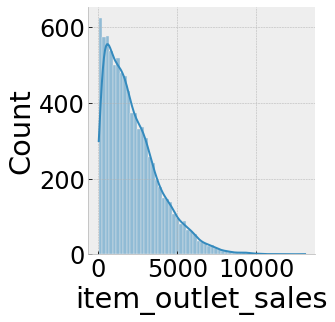

<Figure size 1800x864 with 0 Axes>

In [33]:
a = sns.displot(data=df1, x="item_outlet_sales", kde=True);
plt.show();

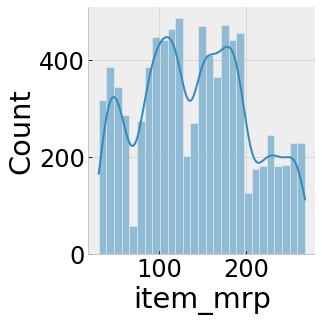

<Figure size 1800x864 with 0 Axes>

In [34]:
sns.displot(data=df1, x="item_mrp", kde=True)
plt.show()

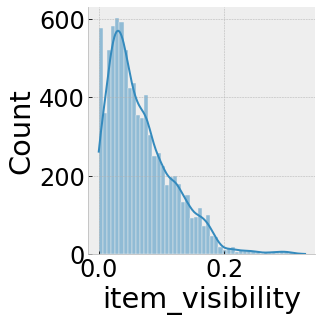

<Figure size 1800x864 with 0 Axes>

In [35]:
sns.displot(data=df1, x="item_visibility", kde=True)
plt.show()

### 1.7.2 Categorical Attributes 

In [22]:
cat_attributes.apply(lambda x: x.unique(). shape[0])

item_identifier         1559
item_fat_content           2
item_type                 16
outlet_identifier         10
outlet_size                3
outlet_location_type       3
outlet_type                4
dtype: int64

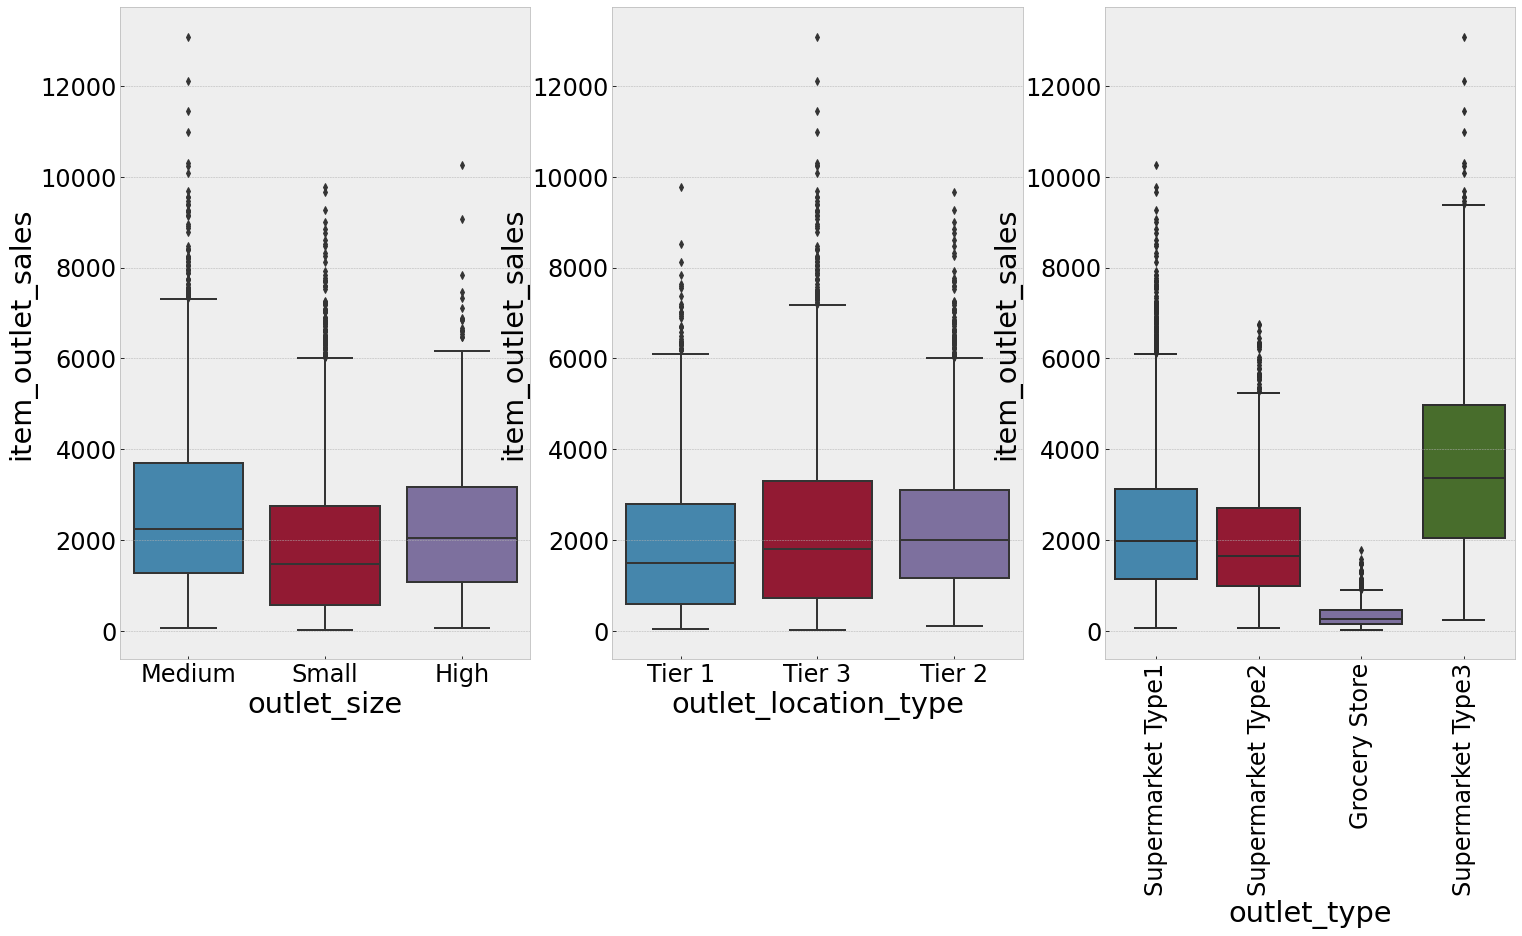

In [23]:
#==========outlet==============
plt.subplot(1,3,1)
sns.boxplot(x='outlet_size', y='item_outlet_sales', data=df1)

plt.subplot(1,3,2)
sns.boxplot(x='outlet_location_type', y='item_outlet_sales', data=df1)

plt.subplot(1,3,3)
sns.boxplot(x='outlet_type', y='item_outlet_sales', data=df1)
plt.xticks(rotation=90);

plt.show()

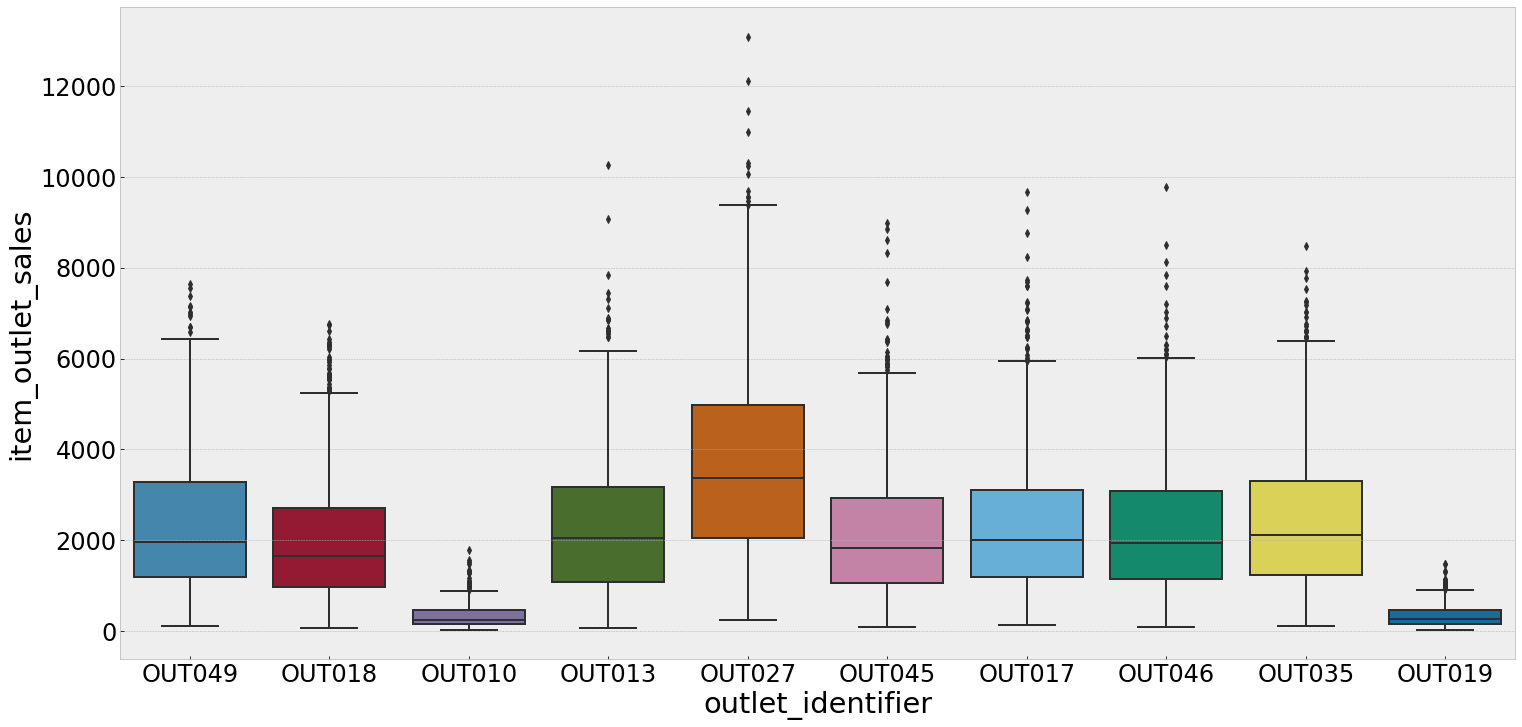

In [24]:
sns.boxplot(x='outlet_identifier', y='item_outlet_sales', data=df1)
plt.show()

In [ ]:
sns.boxplot(x='item_type', y='item_outlet_sales', data=df1)
plt.xticks(rotation=90);
plt.show()

In [ ]:
sns.boxplot(x='item_fat_content', y='item_outlet_sales', data=df1)
plt.show()

# 2.0 - FEATURE ENGINEERING

In [36]:
df2 = df1.copy()

## 2.1 Hypothesis Mental Map 

In [ ]:
Image('img/mindmap.png')

## 2.2 Hypothesis 

### 2.1.1 Outlet hypothesis 

**H1** Bigger outlets should sell more.

**H2** Tier 3 location outlets shoul sell more.

**H3** Supermarket Type1 is the outlet type with more sales.

**H4** Older outlets should sell more.

### 2.1.2 Item hypothesis 

**H5** Regular fat items should sell more.

**H6** Items with bigger visibility should sell more.

**H7** Household items should be more expensive.

**H8** Expensive products should sell less.

**H9** Lighter items should cost less.

**H10** Heavier items should sell less.

### 2.1.3 Time hypothesis 

**H11** Outlets should sell more over the years.

**H12** Weekends should have less sales then weekdays.

**H13** Outlets should sell more in the last quarter of the year.

**H14** Items MRP should increase over the years.

**H15** Items visibility should increase over the years.

## 2.3 Final Hypothesis List 

**H1** Bigger outlets should sell more.

**H2** Tier 3 location outlets shoul sell more.

**H3** Supermarket Type1 is the outlet type with more sales.

**H4** Older outlets should sell more.

**H5** Regular fat items should sell more.

**H6** Items with bigger visibility should sell more.

**H7** Household items should be more expensive.

**H8** Expensive products should sell less.

**H9** Lighter items should cost less.

**H10** Heavier items should sell less.

**H11** Outlets should sell more over the years.

**H12** Items MRP should increase over the years.

**H13** Items visibility should increase over the years.

## 2.4 Feature Engineering 

In [37]:
#outlet_id
df2['outlet_id'] = df2['outlet_identifier'].str.extract(r'(\d{2}$)').astype(int)

# 3.0 - EXPLORATION DATA ANALYSIS (EDA)

In [38]:
df3 = df2.copy()

## 3.1 Univariable Analysis 

### 3.1.1 Response Variable 

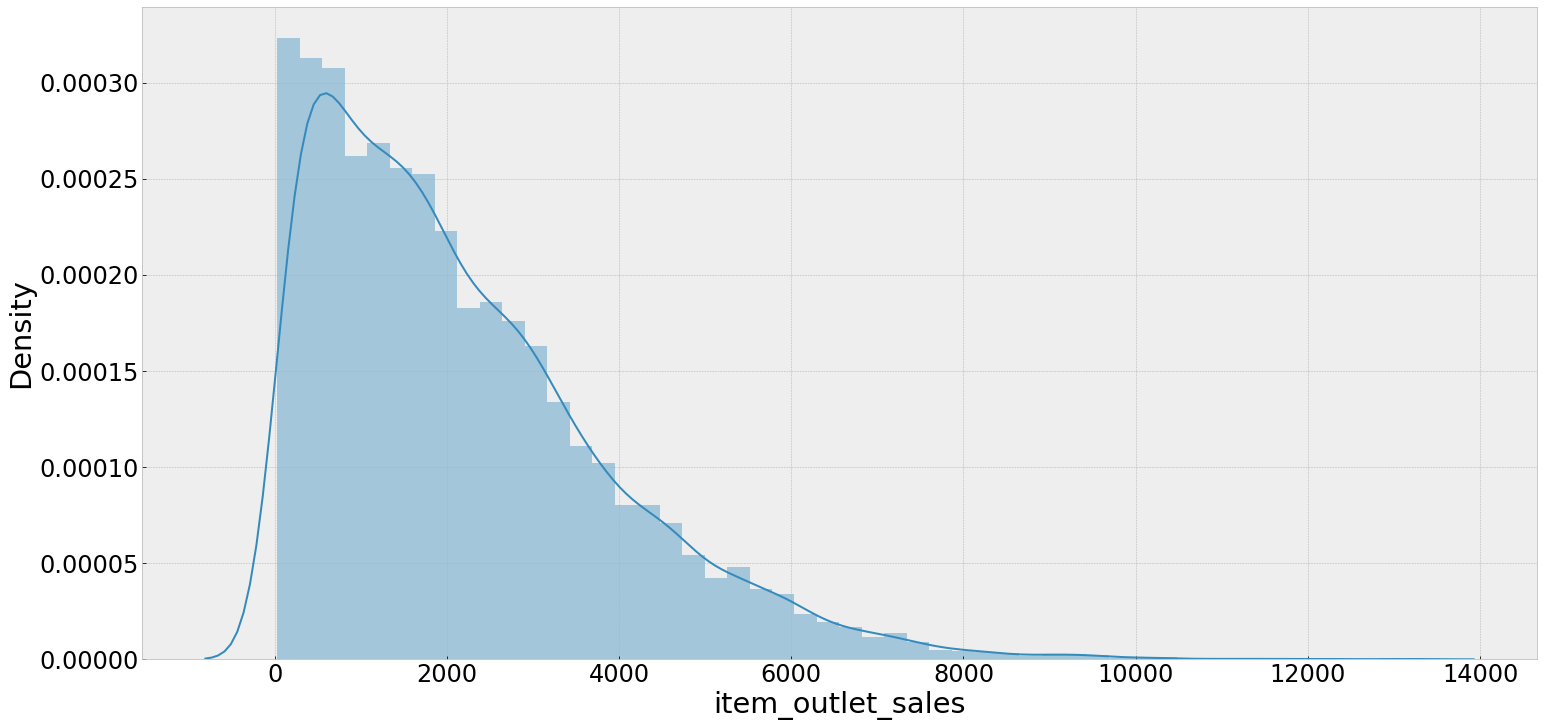

In [39]:
sns.distplot(df3['item_outlet_sales']);

### 3.1.2 Numerical Variables

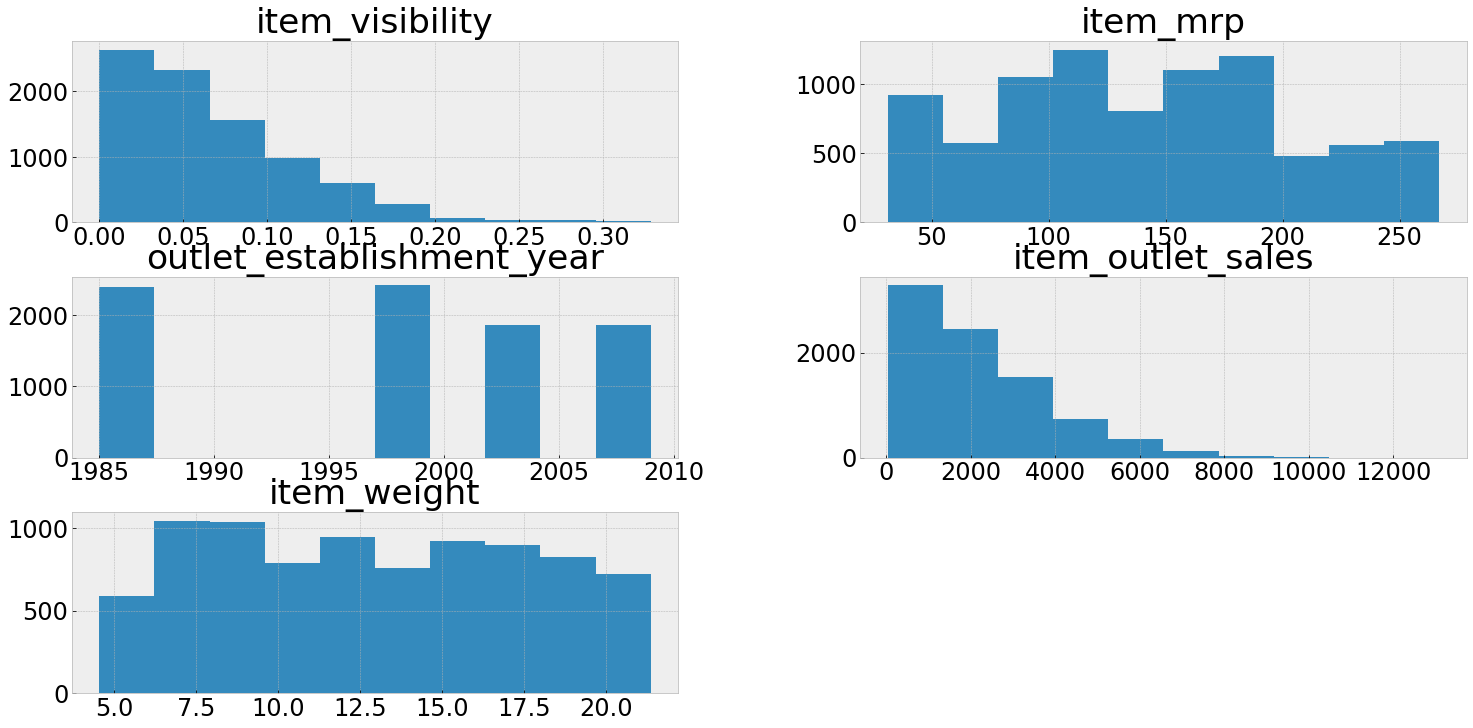

In [40]:
num_attributes.hist();

### 3.1.3 Categorical Variables 

In [ ]:
#item
plt.subplot(1, 1, 1)
sns.countplot(df3['item_fat_content']);
plt.show()

plt.subplot(1, 2, 2)
sns.kdeplot(df3[df3['item_fat_content'] == 'Low Fat']['item_outlet_sales'], label = 'Low Fat', shade=True);
sns.kdeplot(df3[df3['item_fat_content'] == 'Regular']['item_outlet_sales'], label = 'Regular', shade=True);

plt.subplot(2, 2, 1)
sns.countplot(df3['item_type']);
plt.xticks(rotation=90);
plt.show()

plt.subplot(2, 2, 2)
sns.kdeplot(df3[df3['item_type'] == 'Dairy']['item_outlet_sales'], label = 'Dairy', shade=True);
sns.kdeplot(df3[df3['item_type'] == 'Soft Drinks']['item_outlet_sales'], label = 'Soft Drinks', shade=True);
sns.kdeplot(df3[df3['item_type'] == 'Meat']['item_outlet_sales'], label = 'Meat', shade=True);
sns.kdeplot(df3[df3['item_type'] == 'Fruits and Vegetables']['item_outlet_sales'], label = 'Fruits and Vegetables', shade=True);
sns.kdeplot(df3[df3['item_type'] == 'Household']['item_outlet_sales'], label = 'Household', shade=True);
sns.kdeplot(df3[df3['item_type'] == 'Baking Goods']['item_outlet_sales'], label = 'Baking Goods', shade=True);
sns.kdeplot(df3[df3['item_type'] == 'Snack Foods']['item_outlet_sales'], label = 'Snack Foods', shade=True);
sns.kdeplot(df3[df3['item_type'] == 'Frozen Foods']['item_outlet_sales'], label = 'Frozen Foods', shade=True);
sns.kdeplot(df3[df3['item_type'] == 'Breakfast']['item_outlet_sales'], label = 'Breakfast', shade=True);
sns.kdeplot(df3[df3['item_type'] == 'Health and Hygiene']['item_outlet_sales'], label = 'Health and Hygiene', shade=True);
sns.kdeplot(df3[df3['item_type'] == 'Hard Drinks']['item_outlet_sales'], label = 'Hard Drinks', shade=True);
sns.kdeplot(df3[df3['item_type'] == 'Canned']['item_outlet_sales'], label = 'Canned', shade=True);
sns.kdeplot(df3[df3['item_type'] == 'Breads']['item_outlet_sales'], label = 'Breads', shade=True);
sns.kdeplot(df3[df3['item_type'] == 'Starchy Foods']['item_outlet_sales'], label = 'Starchy Foods', shade=True);
sns.kdeplot(df3[df3['item_type'] == 'Others']['item_outlet_sales'], label = 'Others', shade=True);
sns.kdeplot(df3[df3['item_type'] == 'Seafood']['item_outlet_sales'], label = 'Seafood', shade=True);

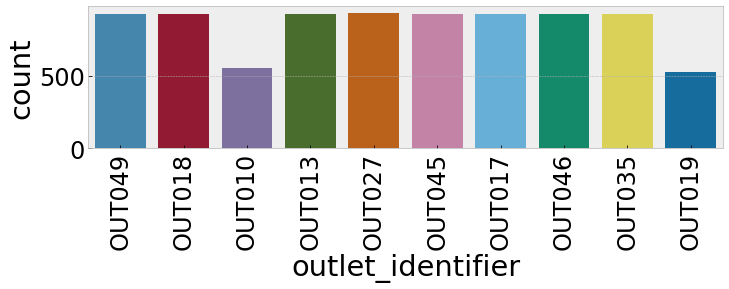

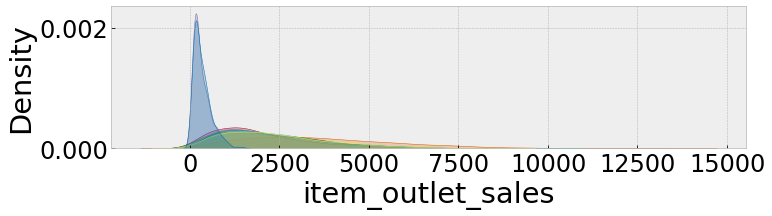

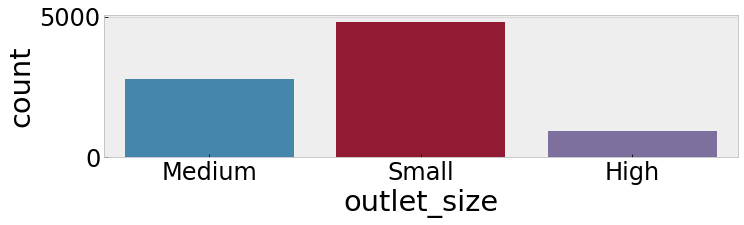

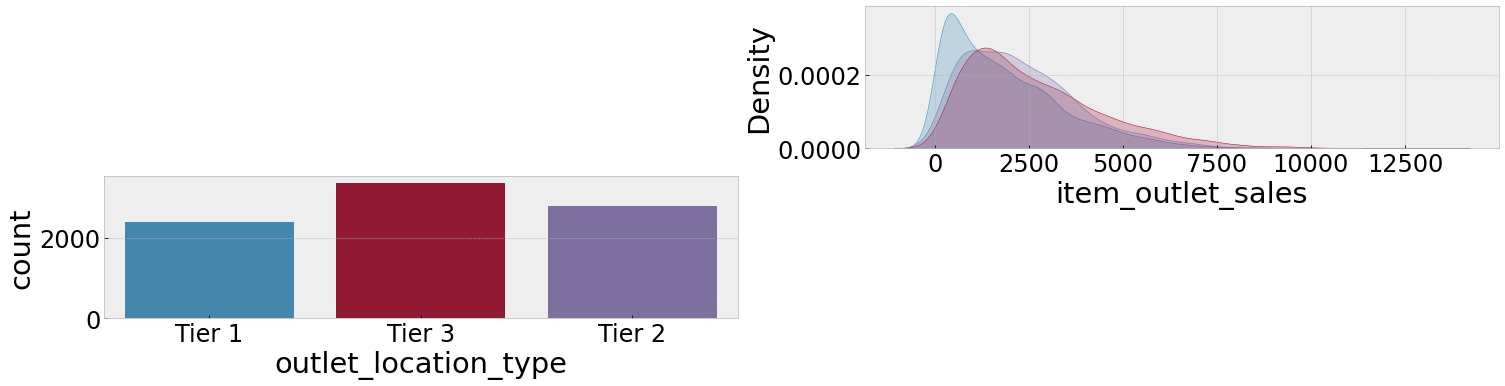

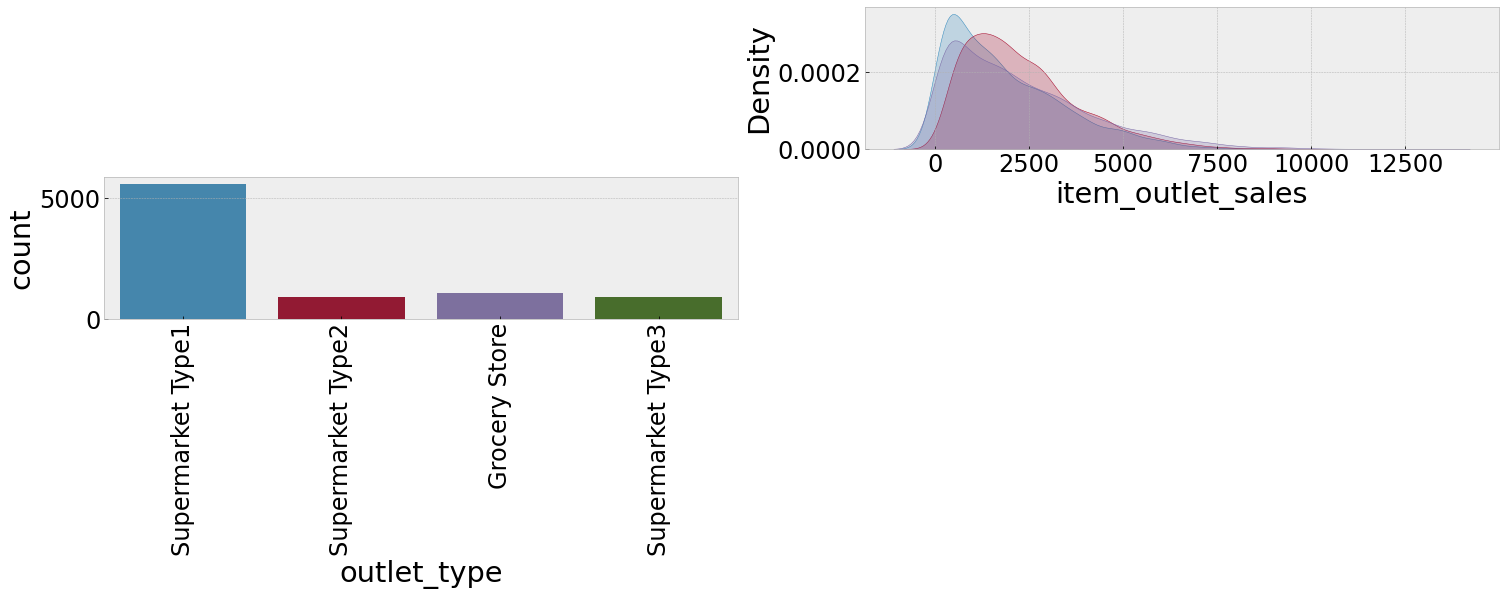

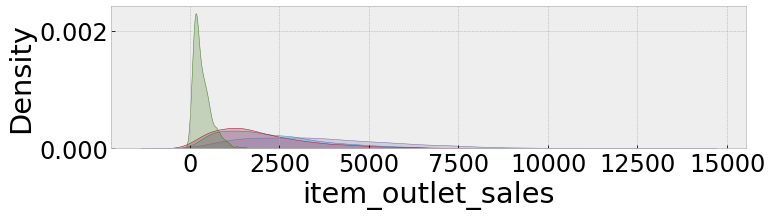

In [41]:
#outlet
plt.subplot(4, 2, 1)
sns.countplot(df3['outlet_identifier']);
plt.xticks(rotation=90);
plt.show()

plt.subplot(4, 2, 2)
sns.kdeplot(df3[df3['outlet_identifier'] == 'OUT049']['item_outlet_sales'], label = 'OUT049', shade=True);
sns.kdeplot(df3[df3['outlet_identifier'] == 'OUT018']['item_outlet_sales'], label = 'OUT018', shade=True);
sns.kdeplot(df3[df3['outlet_identifier'] == 'OUT010']['item_outlet_sales'], label = 'OUT010', shade=True);
sns.kdeplot(df3[df3['outlet_identifier'] == 'OUT013']['item_outlet_sales'], label = 'OUT013', shade=True);
sns.kdeplot(df3[df3['outlet_identifier'] == 'OUT027']['item_outlet_sales'], label = 'OUT027', shade=True);
sns.kdeplot(df3[df3['outlet_identifier'] == 'OUT045']['item_outlet_sales'], label = 'OUT045', shade=True);
sns.kdeplot(df3[df3['outlet_identifier'] == 'OUT017']['item_outlet_sales'], label = 'OUT017', shade=True);
sns.kdeplot(df3[df3['outlet_identifier'] == 'OUT046']['item_outlet_sales'], label = 'OUT046', shade=True);
sns.kdeplot(df3[df3['outlet_identifier'] == 'OUT035']['item_outlet_sales'], label = 'OUT035', shade=True);
sns.kdeplot(df3[df3['outlet_identifier'] == 'OUT019']['item_outlet_sales'], label = 'OUT019', shade=True);
plt.show()


plt.subplot(4, 2, 3)
sns.countplot(df3['outlet_size']);
plt.show()

plt.subplot(4, 2, 4)
sns.kdeplot(df3[df3['outlet_size'] == 'Small']['item_outlet_sales'], label = 'Small', shade=True);
sns.kdeplot(df3[df3['outlet_size'] == 'Medium']['item_outlet_sales'], label = 'Medium', shade=True);
sns.kdeplot(df3[df3['outlet_size'] == 'Large']['item_outlet_sales'], label = 'Large', shade=True);
sns.kdeplot(df3[df3['outlet_size'] == 'High']['item_outlet_sales'], label = 'High', shade=True);

plt.subplot(4, 2, 5)
sns.countplot(df3['outlet_location_type']);
plt.show()

plt.subplot(4, 2, 6)
sns.kdeplot(df3[df3['outlet_location_type'] == 'Tier 1']['item_outlet_sales'], label = 'Tier 1', shade=True);
sns.kdeplot(df3[df3['outlet_location_type'] == 'Tier 2']['item_outlet_sales'], label = 'Tier 2', shade=True);
sns.kdeplot(df3[df3['outlet_location_type'] == 'Tier 3']['item_outlet_sales'], label = 'Tier 3', shade=True);

plt.subplot(4, 2, 7)
sns.countplot(df3['outlet_type']);
plt.xticks(rotation=90);
plt.show()

plt.subplot(4, 2, 8)
sns.kdeplot(df3[df3['outlet_type'] == 'Supermarket Type1']['item_outlet_sales'], label = 'Supermarket Type1', shade=True);
sns.kdeplot(df3[df3['outlet_type'] == 'Supermarket Type2']['item_outlet_sales'], label = 'Supermarket Type2', shade=True);
sns.kdeplot(df3[df3['outlet_type'] == 'Supermarket Type3']['item_outlet_sales'], label = 'Supermarket Type3', shade=True);
sns.kdeplot(df3[df3['outlet_type'] == 'Grocery Store']['item_outlet_sales'], label = 'Grocery Store', shade=True);

## 3.2 Bivariable Analysis 

### **H1** Bigger outlets should sell more.
***FALSE*** Small outlets sell more.

In [ ]:
aux1 = df3[['outlet_size', 'item_outlet_sales']].groupby('outlet_size').sum().reset_index()
sns.barplot(x='outlet_size', y='item_outlet_sales', data=aux1);
plt.show()

aux1 = df3[['outlet_size', 'item_outlet_sales']].groupby('outlet_size').count().reset_index()
sns.barplot(x='outlet_size', y='item_outlet_sales', data=aux1);
plt.show()

### **H2** Tier 3 location outlets shoul sell more.
***TRUE*** Tier 3 location outlets sell more.

In [ ]:
aux1 = df3[['outlet_location_type', 'item_outlet_sales']].groupby('outlet_location_type').sum().reset_index()
sns.barplot(x='outlet_location_type', y='item_outlet_sales', data=aux1);
plt.show()

aux1 = df3[['outlet_location_type', 'item_outlet_sales']].groupby('outlet_location_type').count().reset_index()
sns.barplot(x='outlet_location_type', y='item_outlet_sales', data=aux1);
plt.show()

### **H3** Supermarket Type1 is the outlet type with more sales.
***TRUE*** Supermarket Type1 is the outlet type with more sales.

In [ ]:
aux1 = df3[['outlet_type', 'item_outlet_sales']].groupby('outlet_type').sum().reset_index()
sns.barplot(x='outlet_type', y='item_outlet_sales', data=aux1);
plt.show()

aux2 = df3[['outlet_type', 'item_outlet_sales']].groupby('outlet_type').count().reset_index()
sns.barplot(x='outlet_type', y='item_outlet_sales', data=aux1);
plt.show()

### **H4** Older outlets should sell more.
***TRUE*** The oldest outlet is the one with more sales.

In [ ]:
aux1 = df3[['outlet_establishment_year', 'item_outlet_sales']].groupby('outlet_establishment_year').sum().reset_index()
sns.barplot(x='outlet_establishment_year', y='item_outlet_sales', data=aux1);
plt.show()

aux1 = df3[['outlet_establishment_year', 'item_outlet_sales']].groupby('outlet_establishment_year').count().reset_index()
sns.barplot(x='outlet_establishment_year', y='item_outlet_sales', data=aux1);
plt.show()

sns.heatmap(aux1.corr(method='pearson'), annot=True)
plt.show()

### **H5** Regular fat items should sell more.
***FALSE*** Low Fat items sells more.

In [ ]:
aux1 = df3[['item_fat_content', 'item_outlet_sales']].groupby('item_fat_content').sum().reset_index()
sns.barplot(x='item_fat_content', y='item_outlet_sales', data=aux1);
plt.show()

aux1 = df3[['item_fat_content', 'item_outlet_sales']].groupby('item_fat_content').count().reset_index()
sns.barplot(x='item_fat_content', y='item_outlet_sales', data=aux1);
plt.show()

### **H6** Items with bigger visibility should sell more.
***FALSE*** Items with less them 1% of visibility sells more (there are more products with less visibility then the ones with more).

In [ ]:
aux1 = df3[['item_visibility', 'item_outlet_sales']].groupby('item_visibility').sum().reset_index()
bins = list(np.arange(0, 0.5, 0.1))
aux1['item_visibility_binned'] = pd.cut(aux1['item_visibility'], bins=bins)
aux2 = aux1[['item_visibility_binned', 'item_outlet_sales']].groupby('item_visibility_binned').sum().reset_index()
sns.barplot(x='item_visibility_binned', y='item_outlet_sales', data=aux2);
plt.xticks(rotation=90);
plt.show()

In [ ]:
aux2 = aux1[['item_visibility_binned', 'item_outlet_sales']].groupby('item_visibility_binned').count().reset_index()
aux2

### **H7** Household items should be more expensive.
***TRUE*** Household items are more expensive.

In [ ]:
aux1 = df3[['item_type', 'item_mrp']].groupby('item_type').mean().reset_index().sort_values('item_mrp')
sns.barplot(x='item_type', y='item_mrp', data=aux1);
plt.xticks(rotation=90);
plt.show()

### **H8** Expensive products should sell less.
***FALSE*** Expensive items have a great number of sales.

In [ ]:
aux1 = df3[['item_type','item_outlet_sales']].groupby('item_type').count().reset_index().sort_values('item_outlet_sales')
sns.barplot(x='item_type', y='item_outlet_sales', data=aux1);
plt.xticks(rotation=90);
plt.show()

### **H9** Lighter items should cost less.
***FALSE*** Lighter items are not cheaper then heavier items.

In [ ]:
aux1 = df3[['item_weight', 'item_mrp']].groupby('item_mrp').mean().reset_index()
bins = list(np.arange(4, 23, 1))
aux1['item_weight_binned'] = pd.cut(aux1['item_weight'], bins=bins)
aux2 = aux1[['item_weight_binned', 'item_mrp']].groupby('item_weight_binned').mean().reset_index()
sns.barplot(x='item_weight_binned', y='item_mrp', data=aux2);
plt.xticks(rotation=90);
plt.show()

In [ ]:
aux1 = df3[['item_weight', 'item_mrp']].groupby('item_weight').mean().reset_index()
bins = list(np.arange(4, 23, 1))
aux1['item_weight_binned'] = pd.cut(aux1['item_weight'], bins=bins)
aux2 = aux1[['item_weight_binned', 'item_mrp']].groupby('item_weight_binned').mean().reset_index()
aux2

### **H10** Heavier items should sell less.
***TRUE*** Heavier items sell less then lighter items.

In [ ]:
aux1 = df3[['item_weight', 'item_outlet_sales']].groupby('item_outlet_sales').count().reset_index()
bins = list(np.arange(4, 23, 1))
aux1['item_weight_binned'] = pd.cut(aux1['item_weight'], bins=bins)
aux2 = aux1[['item_weight_binned', 'item_outlet_sales']].groupby('item_weight_binned').count().reset_index()
sns.barplot(x='item_weight_binned', y='item_outlet_sales', data=aux2);
plt.xticks(rotation=90);
plt.show()

### 3.2.1 Hypothesis Resume

In [42]:
tab = [['Hypothesis', 'Conclusion', 'Relevance'],
      ['H1', 'False', 'High'],
      ['H2', 'True', 'High'],
      ['H3', 'True', 'High'],
      ['H4', 'True', 'High'],
      ['H5', 'False', 'Low'],
      ['H6', 'False', 'High'],
      ['H7', 'True', 'Low'],
      ['H8', 'False', 'High'],
      ['H9', 'False', 'Low'],
      ['H10', 'True', 'Low'],
      ]
print(tabulate(tab, headers='firstrow'))

Hypothesis    Conclusion    Relevance
------------  ------------  -----------
H1            False         High
H2            True          High
H3            True          High
H4            True          High
H5            False         Low
H6            False         High
H7            True          Low
H8            False         High
H9            False         Low
H10           True          Low


## 3.3 Multivariable Analysis 

### 3.3.1 Numerical Attributes 

In [ ]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 3.3.2 Categorical Attributes 

In [ ]:
a = df3.select_dtypes(include='object')

In [ ]:
a1 = cramer_v(a['item_fat_content'], a['item_fat_content'])
a2 = cramer_v(a['item_fat_content'], a['item_type'])
a3 = cramer_v(a['item_fat_content'], a['outlet_size'])
a4 = cramer_v(a['item_fat_content'], a['outlet_location_type'])
a5 = cramer_v(a['item_fat_content'], a['outlet_type'])

a6 = cramer_v(a['item_type'], a['item_fat_content'])
a7 = cramer_v(a['item_type'], a['item_type'])
a8 = cramer_v(a['item_type'], a['outlet_size'])
a9 = cramer_v(a['item_type'], a['outlet_location_type'])
a10 = cramer_v(a['item_type'], a['outlet_type'])

a11 = cramer_v(a['outlet_size'], a['item_fat_content'])
a12 = cramer_v(a['outlet_size'], a['item_type'])
a13 = cramer_v(a['outlet_size'], a['outlet_size'])
a14 = cramer_v(a['outlet_size'], a['outlet_location_type'])
a15 = cramer_v(a['outlet_size'], a['outlet_type'])

a16 = cramer_v(a['outlet_location_type'], a['item_fat_content'])
a17 = cramer_v(a['outlet_location_type'], a['item_type'])
a18 = cramer_v(a['outlet_location_type'], a['outlet_size'])
a19 = cramer_v(a['outlet_location_type'], a['outlet_location_type'])
a20 = cramer_v(a['outlet_location_type'], a['outlet_type'])

a21 = cramer_v(a['outlet_type'], a['item_fat_content'])
a22 = cramer_v(a['outlet_type'], a['item_type'])
a23 = cramer_v(a['outlet_type'], a['outlet_size'])
a24 = cramer_v(a['outlet_type'], a['outlet_location_type'])
a25 = cramer_v(a['outlet_type'], a['outlet_type'])



d = pd.DataFrame({'item_fat_content': [a1, a2, a3, a4, a5],
                 'item_type': [a6, a7, a8, a9, a10],
                 'outlet_size': [a11, a12, a13, a14, a15],
                 'outlet_location_type': [a16, a17, a18, a19, a20],
                 'outlet_type': [a21, a22, a23, a24, a25]})
d = d.set_index(d.columns)

In [ ]:
sns.heatmap(d, annot=True);

# 4.0 - DATA PREPARATION

In [43]:
df4 = df3.copy()

## 4.1 Rescaling 

In [44]:
mms = MinMaxScaler()

#item_visibility
df4['item_visibility'] = mms.fit_transform(df4[['item_visibility']].values)
pickle.dump(mms, open('parameter/item_visibility_scaler.pkl', 'wb'))

#item_mrp
df4['item_mrp'] = mms.fit_transform(df4[['item_mrp']].values)
pickle.dump(mms, open('parameter/item_mrp_scaler.pkl', 'wb'))

#item_weight
df4['item_weight'] = mms.fit_transform(df4[['item_weight']].values)
pickle.dump(mms, open('parameter/item_weight_scaler.pkl', 'wb'))

#outlet_establishment_year
df4['outlet_year'] = mms.fit_transform(df4[['outlet_establishment_year']].values)
pickle.dump(mms, open('parameter/outlet_year_scaler.pkl', 'wb'))

## 4.2 Transformation

###  4.2.1 Enconding

In [45]:
le = LabelEncoder()

#item_identifier - label enconding
df4['item_identifier'] = le.fit_transform(df4['item_identifier'])
pickle.dump(le, open('parameter/item_identifier_scaler.pkl', 'wb'))

#item_fat_content - one hot enconding
df4 = pd.get_dummies(df4, prefix=['item_fat_content'], columns=['item_fat_content'])

#item_type - label enconding
type_dict = {'Dairy': 1,
             'Soft Drinks': 2, 
             'Meat': 3, 
             'Fruits and Vegetables': 4,
             'Household': 5, 
             'Baking Goods': 6, 
             'Snack Foods': 7, 
             'Frozen Foods': 8,
             'Breakfast': 9, 
             'Health and Hygiene': 10, 
             'Hard Drinks': 11, 
             'Canned': 12,
             'Breads': 13, 
             'Starchy Foods': 14, 
             'Others': 15, 
             'Seafood': 16}
df4['item_type'] = df4['item_type'].map(type_dict)

#outlet_size - ordinal enconding
size_dict = {'Small': 0, 'Medium': 1, 'High': 2}
df4['outlet_size'] = df4['outlet_size'].map(size_dict)

#outlet_location_type - label enconding
df4['outlet_location_type'] = le.fit_transform(df4['outlet_location_type'])
pickle.dump(le, open('parameter/outlet_location_type_scaler.pkl', 'wb'))

#outlet_type - label enconding 
df4['outlet_type'] = le.fit_transform(df4['outlet_type'])
pickle.dump(le, open('parameter/outlet_type_scaler.pkl', 'wb'))

###  4.2.2 Response Variable Transformation

In [46]:
df4['item_outlet_sales'] = np.log1p(df4['item_outlet_sales'])

# 5.0 - FEATURE SELECTION

In [47]:
df5 = df4.copy()

In [48]:
cols_drop = ['outlet_identifier', 'outlet_establishment_year']
df5 = df5.drop(cols_drop, axis=1)

## 5.1 Split dataframe into training and test

In [49]:
X_train, X_test, y_train, y_test = train_test_split(df5, df5['item_outlet_sales'], train_size=0.8)

## 5.2 Boruta as feature selector 

In [ ]:
#training and test dataset for Boruta
X_train_n = X_train.drop(['item_outlet_sales'], axis=1).values
y_train_n = y_train.values.ravel()

#define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)

#define Boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

### 5.2.1 Best features from Boruta 

In [ ]:
#cols_selected = boruta.support_.tolist()
#features selected
X_train_fs = X_train.drop(['item_outlet_sales'], axis=1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#not selected
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

## 5.3 Manual feature selection 

In [50]:
cols_selected_boruta = ['item_mrp', 'outlet_type', 'outlet_size', 'outlet_id', 'item_identifier', 'outlet_location_type', 'item_visibility', 'outlet_year']

#columns to add
feat_to_add = ['item_outlet_sales']

#final features
cols_full = cols_selected_boruta.copy()
cols_full.extend(feat_to_add)

# 6.0 - MACHINE LEARNING MODELS

In [51]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

#cross validation
x_training = X_train[cols_full]

## 6.1 Average Model

In [52]:
aux1 = x_test.copy()
aux1['item_outlet_sales'] = y_test.copy()

#prediction
aux2 = aux1[['item_identifier', 'item_outlet_sales']].groupby('item_identifier').mean().reset_index().rename(columns={'item_outlet_sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='item_identifier')
yhat_baseline = aux1['predictions']

#performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,520.69,2.04,990.40


In [53]:
aux1 = x_test.copy()
aux1['item_outlet_sales'] = y_test.copy()

#prediction
aux2 = aux1[['outlet_id', 'item_outlet_sales']].groupby('outlet_id').mean().reset_index().rename(columns={'item_outlet_sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='outlet_id')
yhat_baseline = aux1['predictions']

#performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,"1,081.90",1.91,"1,580.84"


## 6.2 Linear Regression Model 

In [54]:
#model
lr = LinearRegression().fit(x_train, y_train)

#prediction
yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,936.56,0.64,"1,359.87"


### 6.2.1 Linear Regression Model - Cross Validation 

In [55]:
#cross validation
lr_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
lr_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,941.16 +/- 0.0,0.64 +/- 0.0,1344.24 +/- 0.0


## 6.3  Linear Regression Regularized Model - Lasso

In [56]:
#model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

#prediction
yhat_lrr = lrr.predict(x_test)

#performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,923.53,0.64,"1,337.79"


### 6.3.1 Linear Regression Lasso - Cross Validation 

In [57]:
#cross validation
lrr_cv = cross_validation(x_training, 5, 'Linear Regression - Lasso', lrr, verbose=False)
lrr_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression - Lasso,923.53 +/- 0.0,0.64 +/- 0.0,1309.58 +/- 0.0


## 6.4 Random Forest Regressor 

In [58]:
#model
rf = RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42).fit(x_train, y_train)

#prediction
yhat_rf = rf.predict(x_test)

#performance
rf_result = ml_error('Random Forest Regressor ', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,790.65,0.51,"1,172.25"


### 6.4.1 Random Forest - Cross Validation 

In [59]:
#cross validation
rf_cv = cross_validation(x_training, 5, 'Random Forest', rf, verbose=False)
rf_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,311.29 +/- 0.0,0.17 +/- 0.0,477.33 +/- 0.0


## 6.5 XGBoost  Regressor

In [60]:
#model
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                             n_estimators=100,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9).fit(x_train, y_train)

#prediction
yhat_model_xgb = model_xgb.predict(x_test)

#performance
model_xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_model_xgb))
model_xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,"2,025.60",0.90,"2,626.87"


### 6.5.1 XGBoost - Cross Validation 

In [61]:
#cross validation
xgb_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False)
xgb_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,2050.58 +/- 0.0,0.9 +/- 0.0,2640.59 +/- 0.0


## 6.6 Compare Model's Performance 

In [64]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, model_xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,790.65,0.51,"1,172.25"
0,Linear Regression - Lasso,923.53,0.64,"1,337.79"
0,Linear Regression,936.56,0.64,"1,359.87"
0,Average Model,"1,081.90",1.91,"1,580.84"
0,XGBoost Regressor,"2,025.60",0.90,"2,626.87"


## 6.7 Cross-Validation 

In [65]:
modelling_result_cv = pd.concat([lr_cv, lrr_cv, rf_cv, xgb_cv])
modelling_result_cv.sort_values(by='RMSE CV', ascending=False)

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,311.29 +/- 0.0,0.17 +/- 0.0,477.33 +/- 0.0
0,XGBoost Regressor,2050.58 +/- 0.0,0.9 +/- 0.0,2640.59 +/- 0.0
0,Linear Regression,941.16 +/- 0.0,0.64 +/- 0.0,1344.24 +/- 0.0
0,Linear Regression - Lasso,923.53 +/- 0.0,0.64 +/- 0.0,1309.58 +/- 0.0


# 7.0 - HYPERPARAMETERS FINE TUNING

## 7.1 Random Search 

In [ ]:
rf = RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)
print('Parameters currently in use:\n')
pprint(rf.get_params())

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
#rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
#rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
#rf_random.fit(x_train, y_train)

## 7.2 Final Model 

In [ ]:
best_params = {'n_estimators': 1600,
               'min_samples_split': 2,
               'min_samples_leaf': 4,
               'max_features': 'sqrt',
               'max_depth': 10,
               'bootstrap': True}

In [66]:
#model
model_rf_tunned = RandomForestRegressor(n_estimators=1600,
                                        min_samples_split=2,
                                        min_samples_leaf=4,
                                        max_features='sqrt',
                                        max_depth=10,
                                        bootstrap=10,
                                        n_jobs=-1, 
                                        random_state=42).fit(x_train, y_train)

#prediction
yhat_model_rf_tunned = model_rf_tunned.predict(x_test)

#performance
model_rf_tunned_result = ml_error('Random Forest Regressor ', np.expm1(y_test), np.expm1(yhat_model_rf_tunned))
model_rf_tunned_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,770.58,0.50,"1,168.33"


In [67]:
#cross validation
model_rf_tunned_cv = cross_validation(x_training, 5, 'Random Forest', model_rf_tunned, verbose=False)
model_rf_tunned_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,700.04 +/- 0.0,0.42 +/- 0.0,1035.46 +/- 0.0


# 8.0 - ERROR INTERPRETETION

In [78]:
df8 = X_test[cols_full]

#rescale
df8['item_outlet_sales'] = np.expm1(df8['item_outlet_sales'])
df8['predictions'] = np.expm1(yhat_model_rf_tunned)

## 8.1 Business Performance

In [ ]:
#sum of predictions
df81 = df8[['outlet_id', 'item_identifier', 'predictions']].groupby(['outlet_id','item_identifier']).sum().reset_index()

#MAE and MAPE
df8_aux1 = df8[['outlet_id', 'item_identifier', 'item_outlet_sales', 'predictions']].groupby([ 'item_identifier']).apply(lambda x: mean_absolute_error(x['item_outlet_sales'], x['predictions'])).reset_index().rename(columns = {0: 'MAE'})
df8_aux2 = df8[['outlet_id', 'item_identifier', 'item_outlet_sales', 'predictions']].groupby(['item_identifier']).apply(lambda x: mean_absolute_percentage_error(x['item_outlet_sales'], x['predictions'])).reset_index().rename(columns = {0: 'MAPE'})

#merge
df8_aux3 = pd.merge(df8_aux1, df8_aux2, how='inner', on='item_identifier')
df82 = pd.merge(df81, df8_aux3, how='left', on='item_identifier')

#scenarios
df82['worst_scenario'] = df82['predictions'] - df82['MAE']
df82['best_scenario'] = df82['predictions'] + df82['MAE']

#order
df82 = df82[['outlet_id', 'item_identifier', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [73]:
df82.sort_values('MAPE', ascending=False).sample(20)

,outlet_id,item_identifier,predictions,worst_scenario,best_scenario,MAE,MAPE
1520,46,1469,674.76,570.35,779.16,104.41,0.22
662,19,438,249.54,218.11,280.97,31.43,0.11
1676,49,1256,"1,302.39",-441.92,"3,046.70","1,744.31",0.57
1582,49,430,"3,244.71","2,577.98","3,911.44",666.73,0.26
1516,46,1448,"1,105.91",922.83,"1,288.99",183.08,0.14
94,10,1311,392.11,170.44,613.77,221.66,1.30
238,13,1163,"1,106.52",254.57,"1,958.47",851.95,0.75
1134,35,1498,"1,464.18",856.88,"2,071.48",607.30,0.71
83,10,1163,185.84,-666.11,"1,037.80",851.95,0.75
699,19,1039,195.33,107.67,282.98,87.66,0.13


In [ ]:
sns.scatterplot(x='item_identifier', y='MAPE', data=df82);

## 8.2 Total Performance

In [75]:
df83 = df82[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenario', 0:'Values'})
df83['Values'] = df83['Values'].map('${:,.2f}'.format)
df83

## 8.3 Machine Learning Performance

In [80]:
df8['error'] = df8['item_outlet_sales'] - df8['predictions']
df8['error_rate'] = df8['predictions'] / df8['item_outlet_sales']

<AxesSubplot:xlabel='predictions', ylabel='error'>

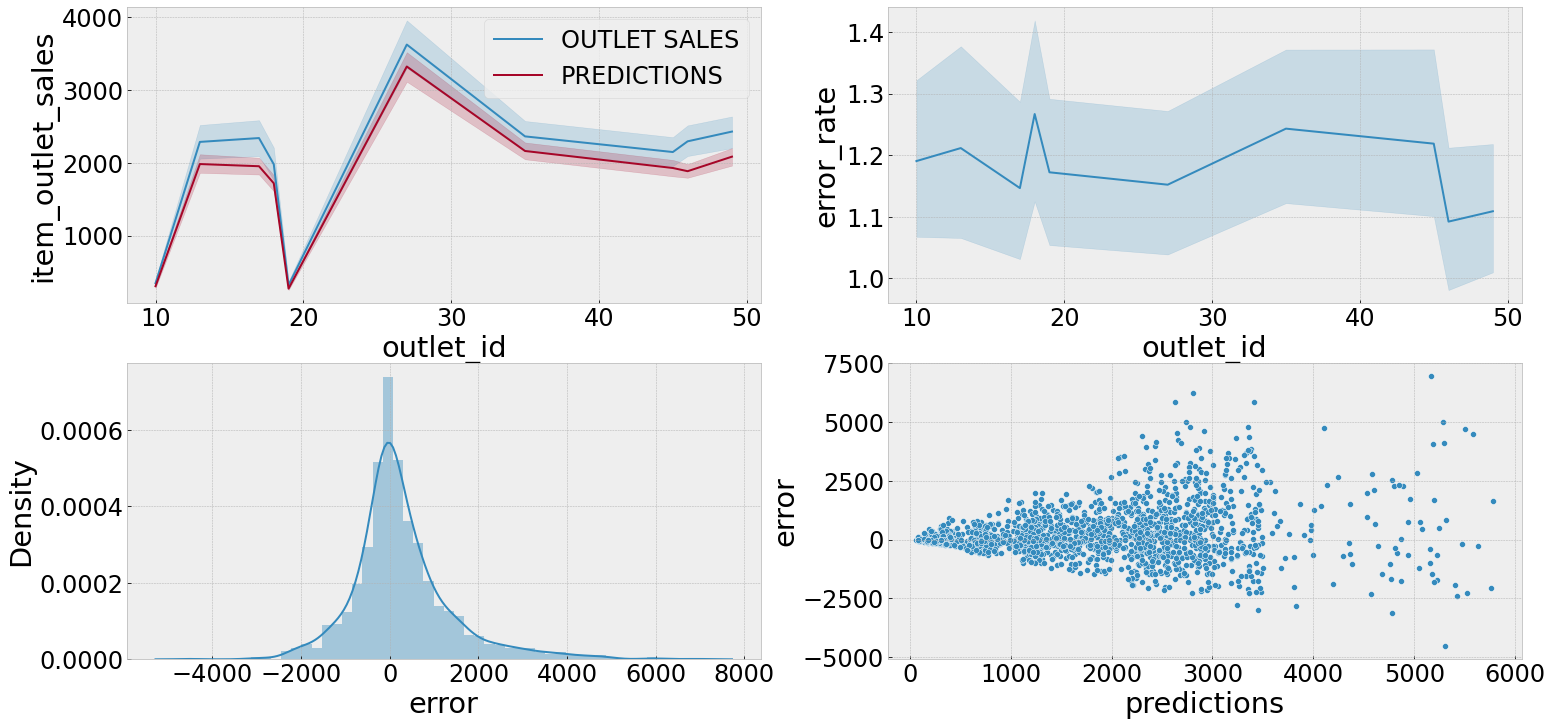

In [81]:
plt.subplot(2,2,1)
sns.lineplot(x='outlet_id', y='item_outlet_sales', data=df8, label='OUTLET SALES')
sns.lineplot(x='outlet_id', y='predictions', data=df8, label='PREDICTIONS')

plt.subplot(2,2,2)
sns.lineplot(x='outlet_id', y='error_rate', data=df8)

plt.subplot(2,2,3)
sns.distplot(df8['error'])

plt.subplot(2,2,4)
sns.scatterplot(df8['predictions'], df8['error'])

# 9.0 - DEPLOY MODEL TO PRODUCTION

In [ ]:
pickle.dump(model_rf_tunned, open('/Users/Giovana/repos/big_mart_sales_prediction/model/model_bigmart.pkl', 'wb'))

## 9.1 BigMart Class

In [ ]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math


class Bigmart(object):
    def __init__(self):
        self.home_path = '/Users/Giovana/repos/big_mart_sales_prediction/'
        self.item_visibility_scaler      = pickle.load(open(self.home_path + 'parameter/item_visibility_scaler.pkl', 'rb'))
        self.item_mrp_scaler             = pickle.load(open(self.home_path + 'parameter/item_mrp_scaler.pkl', 'rb'))
        self.item_weight_scaler          = pickle.load(open(self.home_path + 'parameter/item_weight_scaler.pkl', 'rb'))
        self.outlet_year_scaler          = pickle.load(open(self.home_path + 'parameter/outlet_year_scaler.pkl', 'rb'))
        self.item_identifier_scaler      = pickle.load(open(self.home_path + 'parameter/item_identifier_scaler.pkl', 'rb'))
        self.outlet_location_type_scaler = pickle.load(open(self.home_path + 'parameter/outlet_location_type_scaler.pkl', 'rb'))
        self.outlet_type_scaler          = pickle.load(open(self.home_path + 'parameter/outlet_type_scaler.pkl', 'rb'))


    def data_cleaning(self, df1): 
        ## 1.1 Rename Columns 

        cols_old = ['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
                    'Item_Type', 'Item_MRP', 'Outlet_Identifier',
                    'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
                    'Outlet_Type']
        snakecase = lambda x: inflection.underscore(x)
        cols_new = list(map(snakecase, cols_old))
        df1.columns = cols_new

        ## 1.5 Fillout NA 

        #========item_weight==============
        #create aux item dataframe dataframe
        aux1 = df1[['item_identifier', 'item_weight']].groupby(['item_identifier', 'item_weight']).max()
        df_aux_item = pd.DataFrame(aux1).reset_index()

        #merge aux item dataframe with df1
        df1= pd.merge(df1, df_aux_item, how='left', on='item_identifier')
        df1.drop('item_weight_x', inplace=True, axis=1)
        df1 = df1.rename(columns={'item_weight_y': 'item_weight'})

        #substitute NA left with mean products weight
        mean_weight = df1['item_weight'].mean()
        df1['item_weight'] = df1['item_weight'].fillna(mean_weight)

        #============outlet_size=========== 
        #replace outlet_identifier == OUT010 size for small based on similar OUT019
        df1.loc[df1['outlet_identifier'] == 'OUT010', 'outlet_size'] = 'Small'

        #replace outlet_identifier == OUT017 size for small based on similar majority for Supermarket Type1
        df1.loc[df1['outlet_identifier'] == 'OUT017', 'outlet_size'] = 'Small'

        #replace outlet_identifier == OUT045 size for small based on similar majority for Supermarket Type1
        df1.loc[df1['outlet_identifier'] == 'OUT045', 'outlet_size'] = 'Small'

        ## 1.6 Change variables names
        
        #============item_fat_content=========== 
        #replace low fat to Low Fat
        df1.loc[df1['item_fat_content'] == 'low fat', 'item_fat_content'] = 'Low Fat'

        #replace LF to Low Fat
        df1.loc[df1['item_fat_content'] == 'LF', 'item_fat_content'] = 'Low Fat'

        #replace reg to Regular
        df1.loc[df1['item_fat_content'] == 'reg', 'item_fat_content'] = 'Regular'
        
        return df1
    
    def feature_engineering(self, df2):
        #outlet_id
        df2['outlet_id'] = df2['outlet_identifier'].str.extract(r'(\d{2}$)').astype(int)
        
        return df2
    
    def data_preparation(self, df4): 
        #rescaling
        #item_visibility
        df4['item_visibility'] = self.item_visibility_scaler.fit_transform(df4[['item_visibility']].values)

        #item_mrp
        df4['item_mrp'] = self.item_mrp_scaler.fit_transform(df4[['item_mrp']].values)

        #item_weight
        df4['item_weight'] = self.item_weight_scaler.fit_transform(df4[['item_weight']].values)

        #outlet_establishment_year
        df4['outlet_year'] = self.outlet_year_scaler.fit_transform(df4[['outlet_establishment_year']].values)

        ## 4.2 Transformation
        ###  4.2.1 Enconding
        #item_identifier - label enconding
        df4['item_identifier'] = self.item_identifier_scaler.fit_transform(df4['item_identifier'])

        #item_fat_content - one hot enconding
        df4 = pd.get_dummies(df4, prefix=['item_fat_content'], columns=['item_fat_content'])

        #item_type - label enconding
        type_dict = {'Dairy': 1,
                     'Soft Drinks': 2, 
                     'Meat': 3, 
                     'Fruits and Vegetables': 4,
                     'Household': 5, 
                     'Baking Goods': 6, 
                     'Snack Foods': 7, 
                     'Frozen Foods': 8,
                     'Breakfast': 9, 
                     'Health and Hygiene': 10, 
                     'Hard Drinks': 11, 
                     'Canned': 12,
                     'Breads': 13, 
                     'Starchy Foods': 14, 
                     'Others': 15, 
                     'Seafood': 16}
        df4['item_type'] = df4['item_type'].map(type_dict)

        #outlet_size - ordinal enconding
        size_dict = {'Small': 0, 'Medium': 1, 'High': 2}
        df4['outlet_size'] = df4['outlet_size'].map(size_dict)

        #outlet_location_type - label enconding
        df4['outlet_location_type'] = self.outlet_location_type_scaler.fit_transform(df4['outlet_location_type'])

        #outlet_type - label enconding 
        df4['outlet_type'] = self.outlet_type_scaler.fit_transform(df4['outlet_type'])
        
        cols_selected = ['item_mrp', 'outlet_type', 'outlet_size', 'outlet_id', 'item_identifier', 'outlet_location_type', 'item_visibility', 'outlet_year']

        
        return df4[cols_selected]
    
    def get_prediction(self, model, original_data, test_data):
        #prediction
        pred = model.predict(test_data)
        
        #join pred into the original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient='records')

## 9.2 API Handler 

In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from api.bigmart.Bigmart import Bigmart

#loading model
model = pickle.load(open('/Users/Giovana/repos/big_mart_sales_prediction/model/model_bigmart.pkl', 'rb'))

#initialize api
app = Flask(__name__)
@app.route('/bigmart/predict', methods=['POST'])
def bigmart_predict():
    test_json = request.get_json()
    
    if test_json: #there is data
        if isinstance(test_json, dict): #unique example
            test_raw = pd.DataFrame(test_json, index=[0])
        else: #multiple examples
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
        
        #instantiate Bigmart class
        pipeline = Bigmart()
        
        #data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        #feature engineering
        df2 = pipeline.feature_engineering(df1)
        
        #data preparation
        df3 = pipeline.data_preparation(df2)
        
        #prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
            
    else: 
        return Response('{}', status=200, mimetype='application/json')
if __name__ == '__main__':
    app.run('0.0.0.0')

## 9.3 API Tester 

In [ ]:
#load test dataset
df9 = pd.read_csv('data/test.csv')

In [ ]:
#choose store for prediction
df_test = df9[df9['Outlet_Identifier'] == 'OUT049']

#convert dataframe to json
data = json.dumps(df_test.to_dict(orient='records'))

In [ ]:
#API call
#url = 'http://192.168.15.3:5000/bigmart/predict'
#url = 'http://127.0.0.1:5000/bigmart/predict'
url = 'https://bigmart-model-test.herokuapp.com/bigmart/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, data=data, headers=header)
print('Status Code {}'. format(r.status_code))

In [ ]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [ ]:
pd.options.display.float_format = '{:,.2f}'.format
aux = d1[['item_identifier','prediction']].groupby(['item_identifier']).sum().reset_index().sort_values(ascending=False, by='prediction')
listimage = dfi.export(aux, 'listitemsOUT049.png', max_rows=100)

In [ ]:
d1.head()